In [1]:
# importing necessary packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#!pip install imblearn
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
#rom imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
rs = 12 ### setting a global random_state
pd.set_option('display.max_columns', None)
import json
from sklearn.pipeline import Pipeline
import pickle

# Data Cleaning:

In [2]:
from src.cleaning import read_data, clean_data

In [3]:
data_path = r"C:\Users\brzro\concordia_bootcamp\bank_marketing\data\bank-additional\bank-additional-full.csv"
df = read_data(data_path)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
X,y = clean_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.20, random_state=12, stratify=y_train)

In [7]:
from src.split_scaled import double_split_scale
X_t_scaled, X_v_scaled, X_test_scaled = double_split_scale(X,y)

The data is relatively imbalanced. Hence, I set stratify = yes in the train_test_split function.
Below, we'll see that the response variable (y) is distributed uniformly in different train, validation and test sets.

In [8]:
print(round(y.mean(),4))
print(round(y_t.mean(),4))
print(round(y_v.mean(),4))
print(round(y_test.mean(),4))

0.1127
0.1127
0.1126
0.1127


# Explanatory Data Analysis:

Below we can see that the proportion of people who subscribed to the bank (y =1) vs the proportion of people who do did not.

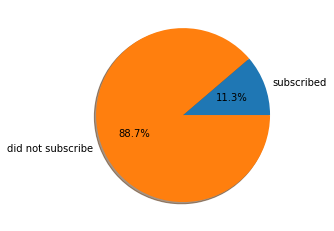

In [9]:
x = [len(df[df['y'] == 'yes'])/len(df), len(df[df['y'] == 'no'])/len(df) ]
plt.pie(x = x, labels=['subscribed', 'did not subscribe'], autopct='%.1f%%', shadow = 'yes');

In the graph below we can see that how the distribution of age is different for those who subscribe to the bank. Thus, including this variable can help us to predict the response variable.  

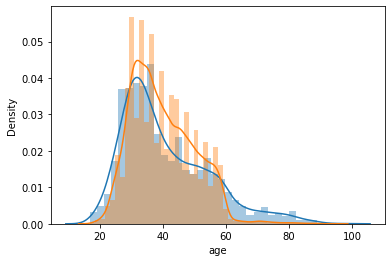

In [10]:
sns.distplot(df[df['y']=='yes']['age'])
sns.distplot(df[df['y']=='no']['age']);

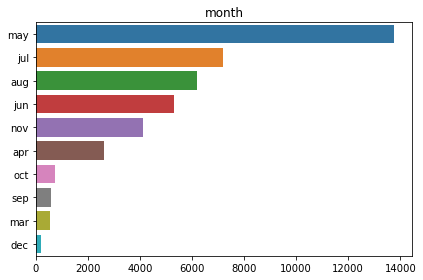

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(df['month'].value_counts().values, df['month'].value_counts().index) # how to add hue
plt.title('month')
plt.tight_layout();

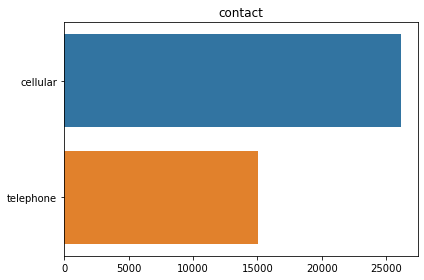

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(df['contact'].value_counts().values, df['contact'].value_counts().index) # how to add hue
plt.title('contact')
plt.tight_layout();

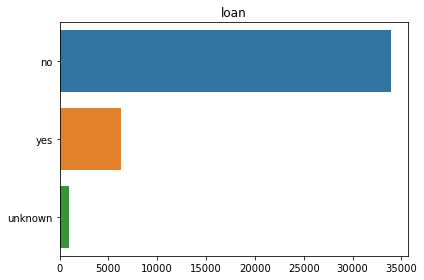

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(df['loan'].value_counts().values, df['loan'].value_counts().index) # how to add hue
plt.title('loan')
plt.tight_layout();

Below, we can see correlation of the numerical variables with the response variable. 'Duration' is only known after bank makes the call. Therefore, it must be removed from the analysis. Including this variable in our analysis results in having a higher model performance (since it is moderatly correlated with y); however, it has no value in what the goal of this project is, which is finding the candidates who are more likely to subscribe to the bank.

By the way why we do care about correlation?

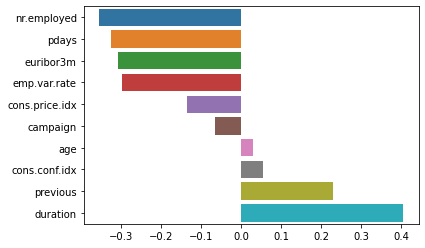

In [14]:
df['y'] = np.where(df['y'] == 'yes', 1, 0)
sns.barplot(df.corr()['y'].sort_values()[:-1].values, df.corr()['y'].sort_values()[:-1].index);

# Machine Learning Models:

To choose the best possible hyperparameters for each of the first three models, I used GridSearchCV.

### 1 - Logistic Regression

In [15]:
from src.logi_regression import logistic_fit, logistic_predictor, logistic_predict_proba
#logistic_fit(X_t, y_t)
pred_lr = logistic_predictor(X_v)
print('The Balanced Accuracy score of the Logistic Regression is:',
      round(balanced_accuracy_score(y_v, pred_lr)*100, 2),'%')

The Balanced Accuracy score of the Logistic Regression is: 72.11 %


In [16]:
pred_proba_lr = logistic_predict_proba(X_v)
AUC = roc_auc_score(y_v, pred_proba_lr)
print('The AUC of the logistic regression is:', round(AUC,2))

The AUC of the logistic regression is: 0.77


### 2 - Support Vector Machines

In [17]:
from src.svm_model import svc_fit, svc_predictor
#svc_fit(X_t_scaled, y_t)
pred_svc = svc_predictor(X_v_scaled)
print('The Balanced Accuracy score of the SVC is:',
      round(balanced_accuracy_score(y_v, pred_svc)*100, 2),'%')

The Balanced Accuracy score of the SVC is: 72.63 %


Support Vector Machines outperform logistic regression by a mere 0.5%. However, I did not choos it as the best model for prediction. This is because this model underestimates the number of the y=1 s. Therefore, it is not in line with the primary goal of the bank which is a profit maximizing problem.

### 3 - Decision Trees

In [18]:
from src.decision_tree import dt_fit, dt_predict_proba, dt_predictor
#dt_fit(X_t_scaled, y_t)
pred_dt = dt_predictor(X_v_scaled)
print('The Balanced Accuracy score of the Decision Tree is:',
      round(balanced_accuracy_score(y_v, pred_dt)*100, 2),'%')

The Balanced Accuracy score of the Decision Tree is: 69.52 %


In [19]:
pred_proba_dt = dt_predict_proba(X_v_scaled)
AUC = roc_auc_score(y_v, pred_proba_dt)
print('The AUC of the Decision Tree is:', round(AUC,2))

The AUC of the Decision Tree is: 0.72


### 4 - Ensemble

Have you seen that a team of normal people can normally beat a smart guy? This is what we want to replicate by using ensemble. We want to use a number of models and then see their predictions for each observation. The final outcome is the majority vote between the models. Also, by altering the hyperparameter 'weight' we can give different weights to each model.

Wasn't it supposed to perform better? why it could not beat the other models? 
One possible (and most probable one in my opinion) is that these models follow a similar pattern to make predictions. Also, we are feeding each with the same training data, and we similar (if not exactly the same) features in each model. Thus, their predictions are correlated with each other, resulting in an accuracy similar to the previous models.

In [20]:
from src.ens import ensemble_fit, ensemble_predictor, ensemble_predict_proba
#ensemble_fit(X_t_scaled, y_t)
pred_ens = ensemble_predictor(X_v_scaled)
print('The Balanced Accuracy of the Ensemble is:',
     round(balanced_accuracy_score(y_v,pred_ens)*100,2), '%')

The Balanced Accuracy of the Ensemble is: 72.1 %


# Performance on the Unseen Data (Test Set)

In [21]:
pred_test = logistic_predictor(X_test)
print('Balanced Accuracy Score of the model on unseen data is', 
     round(balanced_accuracy_score(y_test, pred_test)*100, 2), '%')

Balanced Accuracy Score of the model on unseen data is 73.8 %


In [22]:
pred_proba_test = logistic_predict_proba(X_test)
AUC = roc_auc_score(y_test, pred_proba_test)
print('The AUC of the logistic regression is:', round(AUC,2))

The AUC of the logistic regression is: 0.79


predicting a single row:

In [23]:
from src.final_predictor import predictor

print('The model predicts that the outcome for the row 600 of the test data is:',
      predictor(X_test.iloc[600]))
print('The model predicts that the outcome for the row 602 of the test data is:',
      predictor(X_test.iloc[602]))

The model predicts that the outcome for the row 600 of the test data is: [0]
The model predicts that the outcome for the row 602 of the test data is: [1]


But Seriously, we studied this much to choose logistic regression as the best model?
Talk about the three sources of the error:
- noise
- bias
- variance
Which model does perform better  at the end?

For the deployment part:


In [24]:
x = X_test.iloc[60]
print(predictor(x))
x1 = x.to_json()
x1

[0]


'{"age":56.0,"campaign":2.0,"pdays":0.0,"previous":0.0,"emp.var.rate":1.1,"cons.price.idx":93.994,"cons.conf.idx":-36.4,"euribor3m":4.86,"nr.employed":5191.0,"job_blue-collar":0.0,"job_entrepreneur":0.0,"job_housemaid":0.0,"job_management":1.0,"job_retired":0.0,"job_self-employed":0.0,"job_services":0.0,"job_student":0.0,"job_technician":0.0,"job_unemployed":0.0,"job_unknown":0.0,"marital_married":0.0,"marital_single":0.0,"marital_unknown":0.0,"education_high.school":0.0,"education_illiterate":0.0,"education_professional.course":0.0,"education_university.degree":1.0,"education_unknown":0.0,"default_unknown":0.0,"default_yes":0.0,"housing_unknown":0.0,"housing_yes":1.0,"loan_unknown":0.0,"loan_yes":0.0,"contact_telephone":1.0,"month_aug":0.0,"month_dec":0.0,"month_jul":0.0,"month_jun":0.0,"month_mar":0.0,"month_may":1.0,"month_nov":0.0,"month_oct":0.0,"month_sep":0.0,"day_of_week_mon":0.0,"day_of_week_thu":1.0,"day_of_week_tue":0.0,"day_of_week_wed":0.0,"poutcome_nonexistent":1.0,"poutc

In [171]:
x = X_test.iloc[856]
print(predictor(x))
x1 = x.to_json()
x1

[1]


'{"age":31.0,"campaign":1.0,"pdays":0.0,"previous":0.0,"emp.var.rate":-1.8,"cons.price.idx":93.075,"cons.conf.idx":-47.1,"euribor3m":1.405,"nr.employed":5099.1,"job_blue-collar":0.0,"job_entrepreneur":0.0,"job_housemaid":0.0,"job_management":0.0,"job_retired":0.0,"job_self-employed":0.0,"job_services":0.0,"job_student":0.0,"job_technician":0.0,"job_unemployed":0.0,"job_unknown":0.0,"marital_married":0.0,"marital_single":1.0,"marital_unknown":0.0,"education_high.school":0.0,"education_illiterate":0.0,"education_professional.course":0.0,"education_university.degree":1.0,"education_unknown":0.0,"default_unknown":0.0,"default_yes":0.0,"housing_unknown":0.0,"housing_yes":0.0,"loan_unknown":0.0,"loan_yes":1.0,"contact_telephone":0.0,"month_aug":0.0,"month_dec":0.0,"month_jul":0.0,"month_jun":0.0,"month_mar":0.0,"month_may":0.0,"month_nov":0.0,"month_oct":0.0,"month_sep":0.0,"day_of_week_mon":0.0,"day_of_week_thu":0.0,"day_of_week_tue":0.0,"day_of_week_wed":0.0,"poutcome_nonexistent":1.0,"pou